In [22]:
from __future__ import print_function
from pyem.util import *
from pyem import vop
import numba
import numpy as np
import pyfftw
from pyem.mrc import read
from pyfftw.interfaces.numpy_fft import fftshift
from pyfftw.interfaces.numpy_fft import ifftshift
from pyfftw.interfaces.numpy_fft import rfftn
from pyfftw.interfaces.numpy_fft import irfftn
from pyfftw.interfaces.numpy_fft import rfft2
from pyfftw.interfaces.numpy_fft import irfft2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# %matplotlib notebook
%matplotlib inline
pyfftw.interfaces.cache.enable()

In [8]:
data, hdr = read("example/trpv1_pi4p.mrc", inc_header=True, compat="relion")
relion = np.squeeze(read("example/trpv1_pi4p_proj_30_30_30.mrc", compat="relion"))

In [9]:
def grid_correct(vol, pfac=2, order=1):
    n = vol.shape[0]
    nhalf = n / 2
    x, y, z = np.meshgrid(*[np.arange(-nhalf, nhalf)] * 3, indexing="xy")
    r = np.sqrt(x**2 + y**2 + z**2) / (n * pfac)
    sinc = np.sin(np.pi * r) / (np.pi * r)
    sinc[nhalf, nhalf, nhalf] = 1
    if order == 0:
        gridcor = sinc
        cordata = vol / gridcor
    elif order == 1:
        gridcor = sinc**2
        cordata = vol / gridcor
    else:
        raise NotImplementedError("Only nearest-neighbor and trilinear grid corrections are available")
    return cordata, gridcor

In [10]:
pfac = 2
vol, _ = grid_correct(np.double(data), pfac=pfac, order=1)
padvol = np.pad(vol, (vol.shape[0] * pfac - vol.shape[0]) // 2, "constant")

/software/generic/src/EMAN2.2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  


In [11]:
ft = rfftn(ifftshift(padvol), padvol.shape, threads=8)

In [18]:
@numba.jit(cache=False, nopython=True)
def interpolate_slice_numba(f3d, rot, pfac=2, size=None):
    linterp = lambda a, l, h: l + (h - l) * a
    n = f3d.shape[0] // pfac - 1
    nhalf = n / 2
    if size is None:
        size = n
    phalf = size / 2
    rmax = min(nhalf, (phalf+1) - 1)
    rmax2 = rmax**2
    qot = rot.T * pfac  # Scaling!
    f2d = np.zeros((np.int64(size), np.int64(phalf + 1)), dtype=np.complex64)

    for i in range(size):
        
        if i <= rmax:
            yp = i
        elif i >= size - rmax:
            yp = i - size
        else:
            continue
            
        yp2 = yp ** 2       
        
        for j in range(rmax + 1):
            xp = j
            
            if xp**2 + yp2 > rmax2:
                continue
            
            x = qot[0,0] * xp + qot[0,1] * yp  # Implicit z = 0.
            y = qot[1,0] * xp + qot[1,1] * yp
            z = qot[2,0] * xp + qot[2,1] * yp
            
            if x < 0:
                x = -x
                y = -y
                z = -z
                negx = True
            else:
                negx = False
            
            x0 = np.int(np.floor(x))
            y0 = np.int(np.floor(y))
            z0 = np.int(np.floor(z))
            
            ax = x - x0
            ay = y - y0
            az = z - z0
            
            y0 += n + 1
            z0 += n + 1
            
            x1 = x0 + 1
            y1 = y0 + 1
            z1 = z0 + 1
            
            f2d[i, j] = linterp(az,
                    linterp(ay,
                            linterp(ax, f3d[z0,y0,x0], f3d[z0,y0,x1]),
                            linterp(ax, f3d[z0,y1,x0], f3d[z0,y1,x1])),
                    linterp(ay,
                            linterp(ax, f3d[z1,y0,x0], f3d[z1,y0,x1]),
                            linterp(ax, f3d[z1,y1,x0], f3d[z1,y1,x1])))
            
            if negx:
                f2d[i, j] = np.conj(f2d[i, j])
    return f2d

In [13]:
@numba.jit(cache=True, nopython=True)
def fill_ft(ft, ftc, rmax, normfft=1):
    rmax2 = rmax ** 2
    for k in range(ft.shape[0]):
        kp = k if k < ft.shape[2] else k - ft.shape[0]
        for i in range(ft.shape[1]):
            ip = i if i < ft.shape[2] else i - ft.shape[1]
            for j in range(ft.shape[2]):
                jp = j
                r2 = ip**2 + jp**2 + kp**2
                if r2 <= rmax2:
                    ftc[kp + ftc.shape[0]//2, ip + ftc.shape[1]//2, jp] = ft[k, i, j] * normfft

In [14]:
ftc = np.zeros((387,387,194), dtype=np.complex128)
fill_ft(ft, ftc, 192)

In [15]:
ftc2 = np.pad(ifftshift(ft * 1, axes=(0, 1)), ((2, 1), (2, 1), (0, 1)), "constant")

In [32]:
print ft.shape
print ftc.shape, ftc2.shape
print np.array_equal(ftc, ftc2)

(384, 384, 193)
(387, 387, 194) (387, 387, 194)
False


In [50]:
print np.array_equal(ftc, ftc2 * (r3mask <= (192**2)))

False


In [44]:
r3mask = (np.sum(np.array([np.power(x, 2) for x in 
              np.meshgrid(np.arange(-194,193), np.arange(-194,193), np.arange(0,194))]), axis=0))

In [49]:
np.max(np.abs(ftc[192,:,:] - (ftc2 * (r3mask <=(192**2)))[192,:,:]))

1409.925565490058

/software/generic/src/EMAN2.2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/software/generic/src/EMAN2.2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


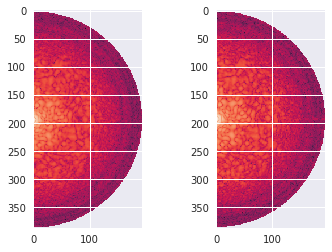

In [48]:
f, ax = plt.subplots(1, 2)
ax[0].imshow(np.log(np.abs((ftc2 * (r3mask <= 192**2))[192,:,:])**2))
# ax[0].imshow(np.log(np.abs((ftc2)[192,:,:])**2))
ax[1].imshow(np.log(np.abs(ftc[192,:,:])**2))

In [19]:
rot = euler2rot(*np.deg2rad(np.array([30, 30, 30])))
sz = 192
# pp = interpolate_slice_numba(fftshift(ft, axes=(0,1)), rot, size=sz)
pp = interpolate_slice_numba(ftc, rot, size=sz)
proj = fftshift(irfft2(pp))

/software/generic/src/EMAN2.2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/software/generic/src/EMAN2.2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


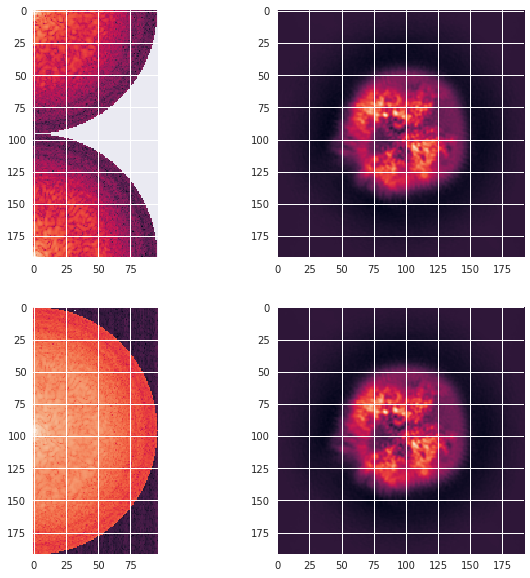

In [137]:
f, ax = plt.subplots(2, 2, figsize=(10,10))
ax[0,0].imshow(np.log(np.abs(pp)**2))
ax[0,1].imshow((proj))
# ax[1,0].imshow(idata.sum(axis=0))
ax[1,0].imshow(fftshift(np.log(np.abs(rfft2(ifftshift(relion)))**2), axes=(0,)))
ax[1,1].imshow(relion)

In [138]:
np.corrcoef(np.vstack([relion.flat, proj.flat]))

array([[ 1.,  1.],
       [ 1.,  1.]])

In [140]:
%timeit interpolate_slice_numba(ftc, rot, size=sz)

The slowest run took 4.39 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 831 µs per loop


In [99]:
xx, yy, zz = np.meshgrid(np.arange(384), np.arange(384), np.arange(193))

In [124]:
xx[192, :, 0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [120]:
cmask = lambda x: x * (r3mask <= 192**2)

In [116]:
xc = np.zeros((387,387,194), dtype=np.int64)

In [117]:
fill_ft(xx, xc, 192)

In [125]:
print xc[193, [0, 1, 2, 3, 4, 5], 0]
print xc[193, [191, 192, 193, 194, 195, 196], 0]
print xc[193, [381, 382, 383, 384, 385, 386], 0]

[  0   0 193 194 195 196]
[382 383   0   1   2   3]
[188 189 190 191 192   0]


In [134]:
xc2 = np.pad(np.fft.ifftshift(xx, axes=(0,1)),((2, 1), (2, 1), (0, 1)), "constant")
print (xc2)[193, [0, 1, 2, 3, 4, 5], 0]
print (xc2)[193, [191, 192, 193, 194, 195, 196], 0]
print (xc2)[193, [381, 382, 383, 384, 385, 386], 0]

[  0   0 192 193 194 195]
[381 382 383   0   1   2]
[187 188 189 190 191   0]


In [129]:
xc3 = np.pad(np.fft.fftshift(xx, axes=(0,1)),((2, 1), (2, 1), (0, 1)), "constant")
print cmask(xc3)[193, [0, 1, 2, 3, 4, 5], 0]
print cmask(xc3)[193, [191, 192, 193, 194, 195, 196], 0]
print cmask(xc3)[193, [381, 382, 383, 384, 385, 386], 0]

[  0   0 192 193 194 195]
[381 382 383   0   1   2]
[187 188 189 190 191   0]


In [133]:
xc2 = np.pad(np.fft.ifftshift(xx, axes=(0,1)),((2, 1), (2, 1), (0, 1)), "constant")
print cmask(xc2)[193, [0, 1, 2, 3, 4, 5], 0]
print cmask(xc2)[193, [191, 192, 193, 194, 195, 196], 0]
print cmask(xc2)[193, [381, 382, 383, 384, 385, 386], 0]

[  0   0 192 193 194 195]
[381 382 383   0   1   2]
[187 188 189 190 191   0]


In [24]:
for v, k in interpolate_slice_numba.inspect_asm().items():
    print(v, k)

(array(complex128, 3d, C), array(float64, 2d, C), omitted(default=2), int64) 	.text
	.file	"<string>"
	.section	.rodata.cst16,"aM",@progbits,16
	.p2align	4
.LCPI0_0:
	.quad	-9223372036854775808
	.quad	-9223372036854775808
	.section	.rodata.cst4,"aM",@progbits,4
	.p2align	2
.LCPI0_1:
	.long	2147483648
	.text
	.globl	_ZN8__main__27interpolate_slice_numba$241E5ArrayI10complex128Li3E1C7mutable7alignedE5ArrayIdLi2E1C7mutable7alignedE24omitted$28default$3d2$29x
	.p2align	4, 0x90
	.type	_ZN8__main__27interpolate_slice_numba$241E5ArrayI10complex128Li3E1C7mutable7alignedE5ArrayIdLi2E1C7mutable7alignedE24omitted$28default$3d2$29x,@function
_ZN8__main__27interpolate_slice_numba$241E5ArrayI10complex128Li3E1C7mutable7alignedE5ArrayIdLi2E1C7mutable7alignedE24omitted$28default$3d2$29x:
	.cfi_startproc
	pushq	%rbp
.Lcfi0:
	.cfi_def_cfa_offset 16
	pushq	%r15
.Lcfi1:
	.cfi_def_cfa_offset 24
	pushq	%r14
.Lcfi2:
	.cfi_def_cfa_offset 32
	pushq	%r13
.Lcfi3:
	.cfi_def_cfa_offset 40
	pushq	%r12
.Lcfi4:
	.cfi_